In [157]:
import vaex as vx
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import scipy as sc
from scipy.interpolate import PchipInterpolator as minterp
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

import os
import sys
import re
from numba import jit
from collections import Counter
from collections import namedtuple
from collections import defaultdict

from sklearn.covariance import OAS
from sklearn.covariance import GraphicalLassoCV
from sklearn.covariance import LedoitWolf
from sklearn.covariance import EmpiricalCovariance



In [158]:
"""
     Information change: 
        * Kullback-Leibler divergence (have to make same number of bins)
        * cross-entropy
        * Shannon entropy change
"""
@jit
def _information_change(v1, v2, ent_type = 'kl', bin_type='fixed', num_bins=25):
    '''
    v1: vector one
    v2: vector two
    ent_type : kl, shannon, cross
    bin_type : auto, fixed
    num_bins : non-zero positive integer
    
    return entropy difference
    '''
    # get bins
    num_bins = num_bins if bin_type=='fixed' else bin_type
    v1bins = np.histogram(v1, density=True, bins=num_bins)
    v2bins = np.histogram(v2, density=True, bins=num_bins)
    
    ent1 = -np.sum(v1bins[0]*np.log2(v1bins[0]))
    ent2 = -np.sum(v2bins[0]*np.log2(v2bins[0]))    
    
    log2v1 = np.log2(v1bins[0])
    log2v2 = np.log2(v2bins[0])
    
    if ent_type == 'shannon':
        return 2*np.abs(ent1-ent2)/(np.abs(ent1)+np.abs(ent2))
    elif ent_type == 'cross':
        cross1 = -np.sum(v1bins[0]*log2v2)
        cross2 = -np.sum(v2bins[0]*log2v1)        
        return 2*np.max([np.abs(cross1),np.abs(cross2)])/(np.abs(ent1)+np.abs(ent2))
    elif ent_type == 'kl':
        return 2*np.max([np.abs(np.sum(v1bins[0]*(log2v1-log2v2))),
                         np.abs(np.sum(v2bins[0]*(log2v2-log2v1)))])/(np.abs(ent1)+np.abs(ent2))


def _cov(x, lib='numpy', method='exact', inverse=False):
    # lib: numpy, scipy, sklearn
    # normalised: True/false  np.corrcoef if true
    # method: exact/shrunk/sparse/empirical
    
    assert method in ['shrunk', 'sparse', 'empirical']
    assert lib in ['numpy', 'scipy', 'sklearn']
    
    if method=='empirical':    
        if (lib=='numpy') | (normalised):
            if normalised:
                cov = np.corrcoef(x)
            else:
                cov = np.cov(x)
            if inverse:
                invcov = np.linalg.inv(cov)
        elif lib=='scipy':
            cov = sc.stats.cov(x)
            if inverse:
                invcov = np.linalg.inv(cov)
        elif lib=='sklearn':
            cm = EmpiricalCovariance().fit(x)
            cov = cm.covariance_
            invconv = cm.precision_
    else:
        if method=='shrunk':
            # return LedoitWolf().fit(x).covariance_
            cm = EmpiricalCovariance().fit(x)
            cov = cm.covariance_
            invcov = cm.precision_
        elif method=='sparse':
            cm = GraphicalLassoCV().fit(x) 
            cov = cm.covariance_
            invcov = cm.precision_
    
    if inverse:
        return cov, invcov
    else:
        return cov, None

@jit
def _Mahalanobis(v1, v2, inv_cov):
    return



@jit
def _skewness(x, logscale=False, bound=False, scale=1000, sample=False, bias=True):
    '''
    x : array(N,1)
    return skewness
    '''
    std = np.std(x)
    mu = np.mean(x)
    N = x.shape[0]
    val = np.sum(np.power(x-mu, 3))/np.power(std, 3)
    if sample==False:
        if bound==False:
            if logscale==False:
                return val
            else:
                return np.log10(np.abs(val))*np.sign(val)
        else:
            return np.tanh(val/scale)
    else:
        return stats.skew(x, bias=bias)

@jit
def _kurtosis(x, logscale=False, sample=False, bias=True):            
    std = np.std(x)
    mu = np.mean(x) 
    val = np.sum(np.power(x-mu, 4))/np.power(std, 4)
    if sample==False:
        if logscale==False:
            return val
        else:
            return np.log10(np.abs(val))*np.sign(val)
    else:
        return stats.kurtosis(x, bias=bias, nan_policy='omit')

@jit
def _stanmom(x, mom=3, logscale=False, mutype=0):
    # mom : 3 is skewness, 4 is kurtosis
    std = np.std(x)
    if mutype==0:
        mu = np.mean(x)
    else:
        mu = np.median(x)
    val = np.sum(np.power(x-mu, mom))/np.power(std, mom)
    if logscale==False:
        return val
    else:
        return np.log10(np.abs(val))*np.sign(val)

@jit
def _rjb(x, C1=6, C2=64):
    n = len(x)
    mu3 = _stanmom(x, mom=3, logscale=False)
    mu4 = _stanmom(x, mom=4, logscale=False)
    J = np.sqrt(np.pi/2.)*np.sum(np.abs(x-np.median(x, axis=0)))
    res = n/C1*(mu3/J**3)**2 + n/C2*(mu4/J**4-3)**2
    return res
    
    
from unidip import UniDip  
import unidip.dip as dip
def _multimodality(x, method='hartigan'):
    x = np.msort(x)
    # multi-modality can be extracted from the number of inflection points on a q-q plot 
    if method=='hartigan':
        return len(UniDip(x).run())
    
def _qq(x, cdist=stats.norm, minkowski=2, plot=None):
    # surface area,max_slope,min_slope
    
    if (len(x.shape)==1):
        vref, v = stats.probplot(x, dist=cdist, plot=plot, fit=False)
        multi=False
    else:
        if x.shape[1]==1:
            vref, v = stats.probplot(x, dist=cdist, plot=plot, fit=False)
        else:
            _cols = x.columns.tolist()
            x = np.array(x)
            vref, v= np.zeros(shape=(x.shape[1], x.shape[0])), np.zeros(shape=(x.shape[1], x.shape[0]))
            for j in range(0, x.shape[1]):
                vref[j, :], v[j, :] = stats.probplot(x[:,j], dist=cdist, plot=None, fit=False)
            multi=True
            
    if multi==False:
        dist_euc = sc.spatial.distance.minkowski(vref, v, p=minkowski)
        mm0 = np.array(np.max(vref)-np.min(vref))
        mm1 = np.array(np.max(v)-np.min(v))
        nsam  = mm0*mm1*0.5
        asam = 0.5*np.sum(np.diff(vref)*(v[:-1]+v[1:]))
        sm = (asam-nsam)/nsam 
        return 0.5*dist_euc/mm0/mm1*sm**2
    else:
        dist_euc = np.diag(sc.spatial.distance.cdist(vref , v, metric='minkowski', p=minkowski))  
        mm0 = np.array(np.max(vref, axis=1)-np.min(vref, axis=1))
        mm1 = np.array(np.max(v, axis=1)-np.min(v, axis=1))
        nsam  = mm0*mm1*0.5
        asam = 0.5*np.sum(np.diff(vref, axis=1)*(v[:, :-1]+v[:, 1:]), axis=1)
        sm = (asam-nsam)/nsam 
        res = np.reshape(0.5*dist_euc/mm0/mm1*sm**2, (1,-1))
        return pd.DataFrame(res, columns=_cols)
    
def _qq2(x1, x2, qbins=15, plot=False, minkowski=2):
    # identify left-skewness, right-skewness, under-dispersed, over-dispersed data
    # see e.g. http://www.ucd.ie/ecomodel/Resources/QQplots_WebVersion.html
    # surface area,max_slope,min_slope
    
    qbins = np.min([qbins, np.min([len(x1), len(x2)])])
    qstep = np.max([1, int(100/qbins)])
    
    perc1 = np.percentile(x1, q=np.arange(0, 100, qstep))
    perc2 = np.percentile(x2, q=np.arange(0, 100, qstep))
    
    if plot:
        plt.plot(perc1, perc2)
        plt.plot([np.min(perc1), np.max(perc1)],[np.min(perc2), np.max(perc2)])
        plt.title('Q-Q')  
        plt.xlabel('q-'+meta_vals[0])
        plt.ylabel('q-'+meta_vals[1])
    
    #dist_cos = sc.spatial.distance.cosine(perc1, perc2)
    dist_euc = sc.spatial.distance.minkowski(perc1, perc2, p=minkowski)
    mm0 = np.max(perc1)-np.min(perc1)
    mm1 = np.max(perc2)-np.min(perc2)
    nsam  = mm0*mm1*0.5
    asam = 0.5*np.sum(np.diff(perc1)*(perc2[:-1]+perc2[1:]))
    # skewed metric
    # positive: left-skewed, negative: right-skewed
    sm = (asam-nsam)/nsam 
    return dist_euc/mm0/mm1*sm**2

@jit
def _wcorr(x1, x2, w):
    '''
    x1, x2 : array of size (N samples,) or (N, m)
    weights : weight of each sample/feature
    returns the weighted Pearson correlation
    '''     
    mu1=np.mean(x1)
    mu2=np.mean(x2)
    xdv = x1-mu1
    yvd = x2-mu2
    c = np.sum(w*xdv*yvd)/np.sqrt(np.sum(w*xdv**2)*np.sum(w*yvd**2))
    return c

def _corr(x1, x2, fun=None):
    '''
    x1, x2 : array of size (N samples,) or (N, m)
    fun: is function object that takes x1,x2,weights as input, e.g. spearmanr, pearsonr, f_oneway
    '''    
    return fun(x1,x2)

def _continuous_sim(x1, x2, fun=None, centered=False, w=None, minkowski=2):
    '''
    x1, x2 : array of size (N samples,) or (N, m)
    fun : chebyshev, cityblock, cosine, euclidean, jensenshannon ([0,1]), mahalanobis, minkowski, canberra, braycurtis
    centered : if True centers x1, x2 around the mean
    weights : weight of each sample/feature
    '''    
    if centered:
        x1 = x1-np.mean(x1)
        x2 = x2-np.mean(x2)
    if fun==None:
        fun = sc.spatial.distance.euclidean
        return fun(x1,x2, w=w)
    else:
        if fun.__name__ == 'minkowski':
            return fun(x1,x2, w=w, p=minkowski)
        else:
            return fun(x1,x2, w=w)

def _boolean_sim(x1, x2, fun=None, w=None):
    '''
    x1, x2 : array of size (N samples,) or (N, m)
    fun : is function object that takes x1,x2,weights as input, e.g. hamming, jaccard, russellrao, kulsinski, sokalmichener, sokalsneath
    weights : weight of each sample/feature
    '''
    if fun==None:
        fun = sc.spatial.distance.hamming    
    return fun(x1,x2,w)

def stat_test_arr(x, test='AD', rescale=False):
    '''
     wrapper to enable application of scipy statistical tests in groupby calls
     test : 'AD', 'KS', 'SW', 'KS'
    '''
    #x = np.array(x)        
    if test == 'AD':
        fun = sc.stats.anderson
        corr = 1
    elif test == 'SW':
        fun = sc.stats.shapiro
        corr = 10
    elif test == 'JB':
        fun = sc.stats.jarque_bera
        corr = 1e5
    elif test == 'KS':
        fun = sc.stats.kstest
        corr = 5
    
    res = np.zeros((1,x.shape[1])) 
    if test in ['AD', 'SW', 'JB']:
        for j in range(0,x.shape[1]):
            if rescale==False:
                res[0,j] = fun(x.iloc[:,j])[0]
            else:
                res[0,j] = np.tanh(fun(x.iloc[:,j])[0]*corr)
    else:
        for j in range(0,x.shape[1]):
            if rescale==False:
                res[0,j] = fun(x.iloc[:,j], 'norm')[0]
            else:
                res[0,j] = np.tanh(fun(x.iloc[:,j], 'norm')[0]*corr)
    return pd.DataFrame(data=res, columns=x.columns)

    

def _cdf(x,bin_size=5):
    x = np.sort(x)
    c = len(x)
    res, _res= np.empty((0, 2)), np.empty((0,2))
    for i in range(bin_size, c):
        if i%bin_size==0:
            _res = np.array([i/c, np.median(x[(i-bin_size):i])])
            res = np.append(res, [_res], axis=0)    
    return res
# np.asarray([[i/c, np.median(x[(i-bin_size):i])] for i in range(bin_size, c) if i%bin_size==0])

@jit
def _cdfcoeff(x, bin_size=5):
    # better to take out the creation of the cdf and split the function (_cdf, _cdfcoeff)
    lt = _cdf(x, bin_size=bin_size)
    xmm = x.max()-x.min()
    diff1 = np.diff(lt[:,1])*lt[:-1, 0]
    diff1[0:1] = 0  
    diff2 = np.diff(diff1)
    diff2[0:1] = 0 
    diff2 = diff2*lt[:-2, 0]

    # modus is peak in f'' followed by valley  in f''
    xmmp = xmm**4
    tv, td = (diff2[0:-1]-diff2[1:]), (np.sign(diff2[0:-1])-np.sign(diff2[1:]))
    xrelcount, xbumpmean, xdiffmean, xdiffvar = (td>0).sum()/(lt.shape[0]-1), tv[tv>0].mean()/xmmp, diff1.mean()/xmmp, diff1.std()/xmmp
    
    return xrelcount, xbumpmean, xdiffmean, xdiffvar

def _interp(xinter, yinter, xextra):
    return minterp(xinter, yinter, axis=0, extrapolate=True)(xextra)

def _cdf_distanceB(x1, x2, bin_size=5, minkowsi=1):
    '''
     takes the Minkowski d492istance between the ecdf's and the Russell-Rao distance of the bump indicators
    ''' 
    lt1 = _cdf(x1, bin_size=bin_size)
    lt2 = _cdf(x2, bin_size=bin_size)

    l1 = _interp(xinter=lt1[:,0], yinter=lt1[:,1], xextra=lt1[:,0])
    l2 = _interp(xinter=lt2[:,0], yinter=lt2[:,1], xextra=lt1[:,0])

    l1diff = np.diff(l1)
    l2diff = np.diff(l2)

    l1diff2 = np.diff(l1diff)
    l2diff2 = np.diff(l2diff)

    l1diff2sign = np.sign(l1diff2)
    l2diff2sign = np.sign(l2diff2)

    l1bump = l1diff2sign[0:-1]-l1diff2sign[1:]
    l2bump = l2diff2sign[0:-1]-l2diff2sign[1:] 

    d1 = sc.spatial.distance.minkowski(l1, l2, p=minkowsi)*sc.spatial.distance.russellrao(l1bump, l2bump)
    d2 = sc.spatial.distance.minkowski(l1diff, l2diff, p=minkowsi)*sc.spatial.distance.russellrao(l1bump, l2bump)
    d3 = sc.spatial.distance.russellrao(l1bump, l2bump)   
    return d1,d2,d3

def _cdf_distanceG(x1, x2, bin_size=15):
    # also see PhD-thesis Gabriel Martos Venturini, Statistical distance and probability metrics for multivariate data..etc., June 2015 Uni. Carlos III de Madrid
    # https://core.ac.uk/download/pdf/30276753.pdf
    '''
     Basically the l1-difference between the cdf's
    '''
    lt1 = _cdf(x1, bin_size=bin_size)
    lt2 = _cdf(x2, bin_size=bin_size)

    l1 = _interp(xinter=lt1[:,0], yinter=lt1[:,1], xextra=lt1[:,0])
    l2 = _interp(xinter=lt2[:,0], yinter=lt2[:,1], xextra=lt1[:,0])    
    
    c = np.max([l1.max(), l2.max()]) - np.min([l1.min(), l2.min()])
    
    diffSumabsAgg= np.sum(lt1[:,0]*(np.abs(l2-l1)))/c # qEMD
    diffSumSqAgg = np.sqrt(np.sum(lt1[:,0]*np.power((l2-l1), 2)))/c # qCvM
    diffSumAgg = np.sum(lt1[:,0]*(l2-l1))/c
    return diffSumAgg, diffSumSqAgg, diffSumabsAgg

def _scaled_stat_distance(x1, x2, test='KS'):
    # scaled with difference between median's
    mdiff = np.median(x2)-np.median(x1)
    return mdiff*stats.ks_2samp(x1, x2)[0]

# ERV differentiation

Two main research questions:
1. Are ERV's differentially expressed in SCC versus AC?
2. Are ERV's involved in immune surveillance in lung cancer

We have to 
* identify ERV's in Adeno and SCC
* identify granzy mand perforin expression per subtype
* identify IFN gene expression per subtype
* silencing of ERV by methylation in normal tissue



In [159]:
max_nans_perc = 0.1

In [160]:
os.chdir('/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/')

In [ ]:
dd = {}
dd['RNAex'] = vx.open('Lung_GeneExpression.hdf5')
dd['mutation'] = vx.open('Lung_Mutation.hdf5')
dd['methylation'] = vx.open('Lung_Methylation.hdf5')
dd['methylation_meta'] = vx.open('HumanMethylation450_meta.hdf5')
dd['CNV'] = vx.open('Lung_CNV.hdf5')

meta = pd.read_csv('Lung_Phenotype_Metadata.txt', sep='\t')
meta = meta.loc[~pd.isna(meta.Diagnosis)]
meta = meta[~meta.SampleID.duplicated(keep='last')]
meta.set_index('SampleID', inplace=True)

In [ ]:
meta.columns

Index(['PatientID', 'Diagnosis', 'Sample Type', 'Gender', 'Ethnicity',
       'Age At Diagnosis (Days)', 'Age At Diagnosis (Years)', 'Vital Status ',
       'Overall Survival Status', 'Time To Overall Survival (Days)',
       'Time To Overall Survival From Treatment (Days)', 'Relapse Status',
       'Time To Relapse From Diagnosis (Days)', 'Event Status',
       'Time To Event From Diagnosis (Days)', 'Karnofsky Score',
       'Smoking Status', 'Pack Years', 'Histological Type', 'Morphology',
       'Site Of Resection', 'Tumor Location', 'Anatomic Location In Lung',
       'Tumor Stage', 'T-stage', 'N-stage', 'M-stage', 'R-stage',
       'Cancer Status After Resection', 'Drug Therapy Type', 'Drug Name',
       'Time To Drug Therapy (Days)', 'Radiation Therapy',
       'Time To Radiation Therapy (Days)', 'Reponse To Therapy',
       'Time To Therapy (Days)', 'Therapy Ongoing', 'New Tumor Event',
       'New Tumor Event Type', 'Time To New Tumor Event (Days)'],
      dtype='object')

In [ ]:
erv_genes = [_gene for _gene in dd['RNAex'].Gene.unique() if 'ERV' in _gene]
erv_genes += [_gene for _gene in dd['methylation'].Gene.unique() if 'ERV' in _gene]
erv_genes = list(set(erv_genes))

In [ ]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5942792/
neutro_gene_list = ['DEFA4', 'DEFA3', 'MMP8', 'CEACAM6', 'CEACAM8', 'LTF', 'MPO', 'ARG1', 'MSHA3']
neutro_genes = [_gene for _gene in dd['RNAex'].Gene.unique() if _gene in neutro_gene_list]
neutro_genes += [_gene for _gene in dd['methylation'].Gene.unique() if _gene in neutro_gene_list]
neutro_genes = list(set(neutro_genes))
# https://www.jimmunol.org/content/175/12/7837.long, http://www.informatics.jax.org/go/term/GO:0033077
t_cell_gene_list = ['CXCR5', 'CXCR3', 'CCR3', 'CCR5', 'CRTH2', 'CCR6', 'CCR7', 'CD3D', 'CD3E', 'CD3G', 'ATG5']
tcell_genes = [_gene for _gene in dd['RNAex'].Gene.unique() if _gene in t_cell_gene_list]
tcell_genes += [_gene for _gene in dd['methylation'].Gene.unique() if _gene in t_cell_gene_list]
tcell_genes = list(set(tcell_genes))
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3219766/, https://www.sciencedirect.com/science/article/pii/S1521690X17300301?via%3Dihub
thyroid_gene_list = ['PDE8B', 'DIO1', 'DIO2', 'CAPZB', 'TSHR', 'THRA', 'THRB', 'MCT8', 'MCT10', 'NTCP', 
                    'SLC10A1', 'SLC10A2', 'SLC16A10', 'LAT1', 'LAT2', 'OATP1A2', 'OATP1B1', 'OATP1B3', 'OATP1C1']
thyroid_genes = [_gene for _gene in dd['RNAex'].Gene.unique() if _gene in thyroid_gene_list]
thyroid_genes += [_gene for _gene in dd['methylation'].Gene.unique() if _gene in thyroid_gene_list]
thyroid_genes = list(set(tcell_genes))
# https://www.sciencedaily.com/releases/2016/08/160822125438.htm, 
thymus_gene_list = ['FOXN1']

In [ ]:
# external
os.chdir('/media/koekiemonster/home/bramiozo/DEV/GIT/RexR/_hackathon2018/_meta_data/gene_types/')
for idx, _file in enumerate(os.listdir(".")):
    _genes = pd.read_csv(_file, sep="\t", index_col=False)
    _genes['gene_class'] = _file.split(".")[0]
    ext_genes = pd.concat([ext_genes, _genes[['Symbol', 'gene_class']]]) if idx>0 else _genes[['Symbol', 'gene_class']]

In [ ]:
for idx, _class in enumerate(ext_genes.gene_class.unique()):
    tmp = ext_genes.loc[ext_genes.gene_class==_class].drop_duplicates()
    cleaned_genes = pd.concat([cleaned_genes, tmp]) if idx>0 else tmp
cleaned_genes.reset_index(drop=True, inplace=True)
ext_genes = cleaned_genes

In [ ]:
thyroid = pd.DataFrame(data=[(_gen, 'thyroid') for _gen in thyroid_genes], columns=['Symbol', 'gene_class'])
tcell = pd.DataFrame(data=[(_gen, 'tcell') for _gen in tcell_genes], columns=['Symbol', 'gene_class'])
thymus = pd.DataFrame(data=[(_gen, 'thymus') for _gen in thymus_gene_list], columns=['Symbol', 'gene_class'])
neutro = pd.DataFrame(data=[(_gen, 'neutro') for _gen in neutro_genes], columns=['Symbol', 'gene_class'])
erv = pd.DataFrame(data=[(_gen, 'erv') for _gen in erv_genes], columns=['Symbol', 'gene_class'])
ext_genes = pd.concat([ext_genes, thyroid, tcell, erv, thymus, neutro])
ext_genes['Symbol'] = ext_genes.Symbol.str.upper()

In [ ]:
gene_list = ext_genes.Symbol.unique()

In [ ]:
df_erv = {}
for _key in dd:  
    d = dd[_key]
    if 'Gene' in d.columns:
        temps = []
        for _gene in tqdm(gene_list):
            temps.append(d[d.Gene.str.upper() == _gene].to_pandas_df())            
        df_erv[_key] = pd.concat(temps, axis=0)
var_cols = {}

  0%|          | 0/995 [00:00<?, ?it/s]

In [ ]:
probe_map = df_erv['methylation'][['probeID', 'Chr', 'Start', 'Stop', 'Strand', 'Gene', 'Relation_CpG_Island']].reset_index().drop('index', axis=1)
df_erv['methylation'] = df_erv['methylation'].drop(['Chr', 'Start', 'Stop', 'Strand', 'Gene', 'Relation_CpG_Island'], axis=1)
df_erv['methylation'].set_index('probeID', inplace=True)
df_erv['methylation'] = df_erv['methylation'].transpose()

max_nans = int(max_nans_perc*df_erv['methylation'].shape[0])
df_erv['methylation'].index = [re.sub(r'_', '-', _old_key) for _old_key in df_erv['methylation'].index.tolist()]
df_erv['methylation'] = df_erv['methylation'].loc[:, df_erv['methylation'].columns[df_erv['methylation'].isna().sum()\
                                                                                   <max_nans].tolist()]
var_cols['methylation'] = df_erv['methylation'].columns.tolist()

In [ ]:
exp_map = df_erv['RNAex'][['Gene', 'Chr', 'Start', 'Stop', 'Strand']].reset_index().drop('index', axis=1)
df_erv['RNAex'] = df_erv['RNAex'].drop(['Chr', 'Start', 'Stop', 'Strand'], axis=1)
df_erv['RNAex'].set_index('Gene', inplace=True)
df_erv['RNAex'] = df_erv['RNAex'].transpose()

max_nans = int(max_nans_perc*df_erv['RNAex'].shape[0])
df_erv['RNAex'].index = [re.sub(r'_', '-', _old_key) for _old_key in df_erv['RNAex'].index.tolist()]
df_erv['RNAex'] = df_erv['RNAex'].loc[:, df_erv['RNAex'].columns[df_erv['RNAex'].isna().sum()\
                                                                                   <max_nans].tolist()]
var_cols['RNAex'] = df_erv['RNAex'].columns.tolist()

In [ ]:
df_erv['mutation'] = df_erv['mutation'][df_erv['mutation'].Effect!='upstream_gene_variant']
mut_map = df_erv['mutation'][['Amino_Acid_Change', 'Gene', 'Chr', 'Start', 'Stop', 'Ref', 'Alt']].reset_index().drop('index', axis=1)
df_erv['mutation'] = df_erv['mutation'].drop(['Gene', 'Chr', 'Start', 'Stop', 'Ref', 'Alt'], axis=1)
df_erv['mutation'] = df_erv['mutation'].reset_index().drop('index', axis=1)
df_erv['mutation'] = df_erv['mutation'].rename(index=str, columns={'Sample_ID': 'SampleID'})
df_erv['mutation'].set_index('SampleID', inplace=True)
var_cols['mutation'] = df_erv['mutation'].columns.tolist()

In [ ]:
cnv_map = df_erv['CNV'][['Gene', 'Chr', 'Start', 'Stop', 'Strand']]
df_erv['CNV'] = df_erv['CNV'].drop(['Chr', 'Start', 'Stop', 'Strand'], axis=1)
df_erv['CNV'] = df_erv['CNV'].set_index('Gene')
df_erv['CNV'] = df_erv['CNV'].transpose()
df_erv['CNV'].index = [re.sub(r'_', '-', _old_key) for _old_key in df_erv['CNV'].index.tolist()]
var_cols['CNV'] = df_erv['CNV'].columns.tolist()

In [ ]:
meta_cols = ['Gender', 'Diagnosis', 'Age At Diagnosis (Years)', 'Overall Survival Status', 'Pack Years', 'Smoking Status']
meta_cols = meta_cols + ['New Tumor Event', 'Radiation Therapy', 'Reponse To Therapy', 'Drug Therapy Type']

stage_map = {'stage i': 'stage 1', 'stage ia': 'stage 1', 'stage ib': 'stage 1',
             'stage ii': 'stage 2', 'stage iia': 'stage 2', 'stage iib': 'stage 2',
             'stage iii': 'stage 3','stage iiia': 'stage 3', 'stage iiib': 'stage 3',
             'stage iv' : 'stage 4'}
meta['Stage'] = meta['Tumor Stage'].map(stage_map)
########
smoke_map = {'Current Reformed Smoker < or = 15 yrs': 'reformed', 
             'Current Reformed Smoker for > 15 yrs': 'reformed',
             'Current Reformed Smoker, Duration Not Specified': 'reformed',
             'Current Smoker': 'current',
             'Lifelong Non-Smoker': 'non-smoker'}
meta['Smoking'] = meta['Smoking Status'].map(smoke_map)
########
response_map = {'Progressive Disease': 'no',
                'Complete Remission/Response': 'yes',
                'Stable Disease': 'no',
                'Partial Remission/Response': 'yes'}
meta['Response'] = meta['Reponse To Therapy'].map(response_map)
meta_cols = list(set(meta_cols + ['Stage', 'Smoking', 'Response']))

for _key in df_erv:
    df_erv[_key] = df_erv[_key].join(meta[meta_cols])

In [ ]:
df_erv.keys()

# Check differentiation per feature

In [ ]:
#probe_map # probID -> Gene
#ext_genes # Symbol -> gene_class

## Methylation

In [ ]:
len(var_cols['methylation'])

In [ ]:
i=9999
meta_col = 'Diagnosis' # 
meta_vals = df_erv['methylation'][meta_col].unique().tolist()
val_series = []
probe = var_cols['methylation'][i]
gene = probe_map.loc[probe_map.probeID==probe]['Gene'].values[0]
gene_class = ext_genes.loc[ext_genes.Symbol==gene]['gene_class'].values[0]
for _meta_col_val in meta_vals:
    if pd.isna(_meta_col_val)==False:
        x = df_erv['methylation'].loc[df_erv['methylation'][meta_col]==_meta_col_val, probe]
        x.plot.hist(bins=20, alpha=0.5, density=True, label=_meta_col_val)
        x.plot.kde(color='black', label='')
        val_series.append(x)
plt.title(meta_col+' , '+var_cols['methylation'][i]+' ,  '+gene+' , '+gene_class)
plt.legend()
plt.xlim(0., 1.1)

In [ ]:
# Wasserstein distance per gene class
dist_list_diag = []
for _probe in tqdm(var_cols['methylation']):
    v1 = df_erv['methylation'].loc[df_erv['methylation']['Diagnosis']=='Lung Adenocarcinoma', _probe]
    v2 = df_erv['methylation'].loc[df_erv['methylation']['Diagnosis']=='Lung Squamous Cell Carcinoma', _probe]
    
    try:
        cd1 = _cdf_distanceB(v1, v2)
        cd2 = _cdf_distanceG(v1, v2)
    except ValueError as e:
        v1 = np.isfinite(v1)
        v2 = np.isfinite(v2)
        cd1 = _cdf_distanceB(v1, v2)
        cd2 = _cdf_distanceG(v1, v2)
    dist_list_diag.append({'probe': _probe, 
                      'Bdist1': cd1[0],
                      'Bdist2': cd1[1],
                      'Bdist3': cd1[2],
                      'Gdist1': cd2[0], 
                      'Gdist2': cd2[1],
                      'Gdist3': cd2[2],
                      'wass1' : stats.wasserstein_distance(v1,v2),
                      'wass2' : stats.energy_distance(v1,v2),
                      'statdistKS': _scaled_stat_distance(v1,v2)
                      })

In [ ]:
dist_list_response = []
for _probe in tqdm(var_cols['methylation']):
    v1 = df_erv['methylation'].loc[df_erv['methylation']['Response']=='yes', _probe]
    v2 = df_erv['methylation'].loc[df_erv['methylation']['Response']=='no', _probe]
    
    try:
        cd1 = _cdf_distanceB(v1, v2)
        cd2 = _cdf_distanceG(v1, v2)
    except ValueError as e:
        v1 = np.isfinite(v1)
        v2 = np.isfinite(v2)
        cd1 = _cdf_distanceB(v1, v2)
        cd2 = _cdf_distanceG(v1, v2)
    dist_list_response.append({'probe': _probe, 
                      'Bdist1': cd1[0],
                      'Bdist2': cd1[1],
                      'Bdist3': cd1[2],
                      'Gdist1': cd2[0], 
                      'Gdist2': cd2[1],
                      'Gdist3': cd2[2],
                      'wass1' : stats.wasserstein_distance(v1,v2),
                      'wass2' : stats.energy_distance(v1,v2),
                      'statdistKS': _scaled_stat_distance(v1,v2)
                      })

In [ ]:
dist_list_df = pd.DataFrame(dist_list_response)
dist_list_df = dist_list_df.merge(probe_map[['probeID', 'Gene']], how='inner', left_on='probe', right_on='probeID')
dist_list_df = dist_list_df.merge(ext_genes, how='inner', left_on='Gene', right_on='Symbol')
agg_by_gene = dist_list_df.groupby('Gene').mean()

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(24,18))
dist_list_df.sort_values(by='statdistKS', ascending=False)[:1000].groupby('gene_class').size().plot.bar(ax=ax[0,0])
dist_list_df.sort_values(by='statdistKS', ascending=True)[:1000].groupby('gene_class').size().plot.bar(ax=ax[0,1])
sns.scatterplot(data=dist_list_df, x='wass1', y='statdistKS', hue='gene_class', alpha=0.3, ax=ax[1,0])
sns.scatterplot(data=dist_list_df, x='wass1', y='wass2', hue='gene_class', alpha=0.3, ax=ax[1,1])
plt.suptitle("Lung cancer response methylation differentiation")

In [21]:
'''
Univariated intra-distribution characterisations:
    * [x] skewness
    * [x] kurtosis
    * normality test
        * [x] q-qnorm metrics
        * [x] Shapiro-Wilk
        * [x] Anderson-Darling
        * [x] Jarque-Bera
        * [x] Gel-Gastwirth test, see https://ideas.repec.org/a/eee/ecolet/v99y2008i1p30-32.html
        * [x] KS-goodness of fit
'''

'''
 function add_stat_agg(df, agg_val='Diagnosis')
'''

stat_cat = defaultdict(dict)
stat_cat['methylation']['skewness'] = df_erv['methylation']\
                            .loc[:, var_cols['methylation']+['Diagnosis']]\
                            .groupby('Diagnosis')\
                            .apply(lambda x: _stanmom(x, mom=3, logscale=True)).transpose()

stat_cat['methylation']['kurtosis'] = df_erv['methylation']\
                            .loc[:, var_cols['methylation']+['Diagnosis']]\
                            .groupby('Diagnosis')\
                            .apply(lambda x: _stanmom(x, mom=4, logscale=True)).transpose()

stat_cat['methylation']['qqnorm'] = df_erv['methylation'].loc[:, var_cols['methylation']+['Diagnosis']]\
                     .groupby('Diagnosis')\
                     .apply(lambda x: _qq(x, minkowski=2)).reset_index(level=1)
stat_cat['methylation']['qqnorm'] = stat_cat['methylation']['qqnorm'].drop('level_1', axis=1)
stat_cat['methylation']['qqnorm'] = stat_cat['methylation']['qqnorm'].transpose()

stat_cat['methylation']['mean'] = df_erv['methylation'].loc[:, var_cols['methylation']+['Diagnosis']]\
                     .groupby('Diagnosis')\
                     .mean().transpose()

stat_cat['methylation']['median'] = df_erv['methylation'].loc[:, var_cols['methylation']+['Diagnosis']]\
                     .groupby('Diagnosis')\
                     .median().transpose()

stat_cat['methylation']['q75'] = df_erv['methylation'].loc[:, var_cols['methylation']+['Diagnosis']]\
                     .groupby('Diagnosis')\
                     .quantile(0.75).transpose()

stat_cat['methylation']['q25'] = df_erv['methylation'].loc[:, var_cols['methylation']+['Diagnosis']]\
                     .groupby('Diagnosis')\
                     .quantile(0.25).transpose()

stat_cat['methylation']['AD'] = df_erv['methylation'].loc[:, var_cols['methylation']+['Diagnosis']]\
                     .groupby('Diagnosis')\
                     .apply(lambda x: stat_test_arr(x, test='AD')).reset_index(level=1)
stat_cat['methylation']['AD'] = stat_cat['methylation']['AD'].drop('level_1', axis=1)
stat_cat['methylation']['AD'] = stat_cat['methylation']['AD'].transpose()

stat_cat['methylation']['SW'] = df_erv['methylation'].loc[:, var_cols['methylation']+['Diagnosis']]\
                     .groupby('Diagnosis')\
                     .apply(lambda x: stat_test_arr(x, test='SW')).reset_index(level=1)
stat_cat['methylation']['SW'] = stat_cat['methylation']['SW'].drop('level_1', axis=1)
stat_cat['methylation']['SW'] = stat_cat['methylation']['SW'].transpose()


stat_cat['methylation']['JB'] = df_erv['methylation'].loc[:, var_cols['methylation']+['Diagnosis']]\
                     .groupby('Diagnosis')\
                     .apply(lambda x: stat_test_arr(x, test='JB')).reset_index(level=1)
stat_cat['methylation']['JB'] = stat_cat['methylation']['JB'].drop('level_1', axis=1)
stat_cat['methylation']['JB'] = stat_cat['methylation']['JB'].transpose()

stat_cat['methylation']['RJB'] = df_erv['methylation'].loc[:, var_cols['methylation']+['Diagnosis']]\
                     .groupby('Diagnosis')\
                     .apply(lambda x: _rjb(x, C1=6, C2=64)).transpose()

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1789: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1875: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 11 results
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 5 results
  r = func(a, **k

In [22]:
'''
Univariate inter-distribution distance:    
        * _information_change: KL, Cross, Shannon
        * Kolmogorov-Smirnov (also normality test)
        * Pearson's chi-squared test (only if all vars are binned and categorised)
        * Mann-Whitney U
        * Brunner Munzel
        * Bonett-Seier test
        * Kruskall Wallis
        * FDR-BH-ANOVA
        * total variation distance
        * Hellinger distance
        * Bhattacharyya distance
        * KS goodness of fit
        * [x] q-q distances (CvM, nth-Wasserstein, etc.)
        * [x] CDF distance 
        
    
        function add_inter_dist(df, split_cols, split_val='Diagnosis')
'''



"\nUnivariate inter-distribution distance:    \n        * _information_change: KL, Cross, Shannon\n        * Kolmogorov-Smirnov (also normality test)\n        * Pearson's chi-squared test (only if all vars are binned and categorised)\n        * Mann-Whitney U\n        * Brunner Munzel\n        * Bonett-Seier test\n        * Kruskall Wallis\n        * FDR-BH-ANOVA\n        * total variation distance\n        * Hellinger distance\n        * Bhattacharyya distance\n        * KS goodness of fit\n        * [x] q-q distances (CvM, nth-Wasserstein, etc.)\n        * [x] CDF distance \n        \n    \n        function add_inter_dist(df, split_cols, split_val='Diagnosis')\n"

In [23]:
'''
also see: https://towardsdatascience.com/select-features-for-omics-integration-511390b7e7fd
inter-class separation scores:
 - ElasticNet - binomial
 - LR
 - PLS-DA
 - LDA
 - bi-GAM
'''

'\nalso see: https://towardsdatascience.com/select-features-for-omics-integration-511390b7e7fd\ninter-class separation scores:\n - ElasticNet - binomial\n - LR\n - PLS-DA\n - LDA\n - bi-GAM\n'

In [24]:
# we extract the weights as weights for the similarity check later

In [25]:
'''
    similarity -> dissimilarity:
    * d = 1 - s
    * d = sqrt(s(x,x)+s(y,y)-2s(x,y))
    * d= -log(s(x,y))
'''

'''
    dissimilarity -> similarity:
    * s = exp(-d(x,y)/sigma)
    * s = 1/(1+d(x,y))
    * s = 1/2*(d^2(x,c) + d^2(y,c)-d^2(x,y))
    
'''

'\n    dissimilarity -> similarity:\n    * s = exp(-d(x,y)/sigma)\n    * s = 1/(1+d(x,y))\n    * s = 1/2*(d^2(x,c) + d^2(y,c)-d^2(x,y))\n    \n'

SpearmanrResult(correlation=0.8121215440283412, pvalue=2.4812411236005357e-38) (0.7877666845079856, 1.197629286536355e-34) F_onewayResult(statistic=1.3830302256878222, pvalue=0.24047650943440946)
0.7877666845079854
0.2122333154920144


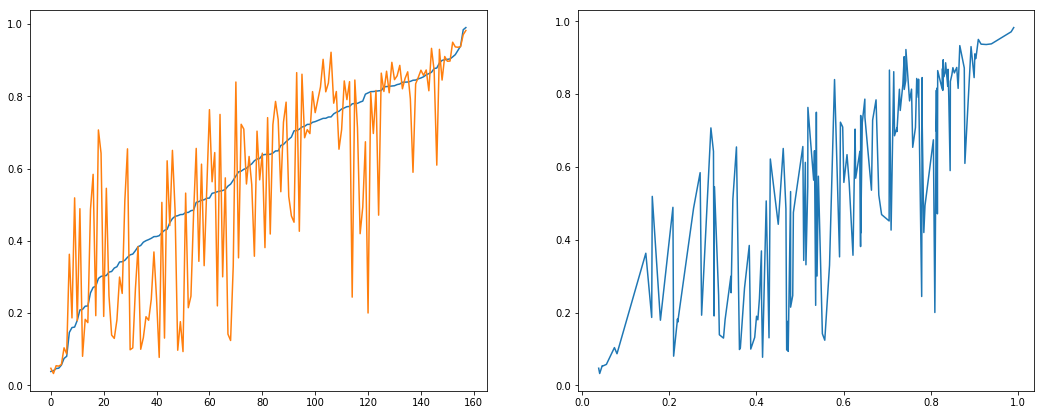

In [31]:
v1 = np.array(df_erv['methylation'][var_cols['methylation']].iloc[41,:])
v2 = np.array(df_erv['methylation'][var_cols['methylation']].iloc[151,:])
indexsort = np.argsort(v1)

fig, ax = plt.subplots(ncols=2, figsize=(18,7))
ax[0].plot(v1[indexsort])
ax[0].plot(v2[indexsort])
ax[1].plot(v1[indexsort], v2[indexsort])

print(_corr(v1, v2, fun=sc.stats.spearmanr), _corr(v1, v2, fun=sc.stats.pearsonr), _corr(v1, v2, fun=sc.stats.f_oneway))
w = np.ones(shape=v1.shape)
print(_wcorr(v1, v2, w))
print(_continuous_sim(v1, v2, fun=sc.spatial.distance.cosine, centered=True, w=w))

In [28]:
'''
Pairwise distance:
    * Manhattan distance (only if all vars are binned and categorised)
    * Euclidean distance
    * Pearson  distance To be consistent with data protection laws, we’re asking you to take a moment to review key points of our Privacy Policy, which covers all Google services and describes how we use data and what options you have. We'll need you to do this today.
NL

    * Kendall distance 
    * Spearman distance
    * 1-Cosine distance (pseudometric)
    * Mahalanobis distance
'''

"\nPairwise distance:\n    * Manhattan distance (only if all vars are binned and categorised)\n    * Euclidean distance\n    * Pearson  distance To be consistent with data protection laws, we’re asking you to take a moment to review key points of our Privacy Policy, which covers all Google services and describes how we use data and what options you have. We'll need you to do this today.\nNL\n\n    * Kendall distance \n    * Spearman distance\n    * 1-Cosine distance (pseudometric)\n    * Mahalanobis distance\n"

In [29]:
# get inter-dataset feature-feature similarity 

# get sample-sample similarity
# cluster samples 

# use NN to find similar patient clusters https://github.com/spotify/annoy

## make N s-s-s bins 


# R: mixOmics, https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005752
# DIABLO: https://www.biorxiv.org/content/10.1101/067611v2
# Multiscale, multifactorial response network (MMRN)
# https://www.nature.com/articles/s41467-019-08794-x.pdf
# https://www.sciencedirect.com/science/article/pii/S2452310018301197#undfig1
# https://www.cell.com/cell-systems/fulltext/S2405-4712(17)30548-3
# https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-12-253

In [30]:
# what combination of dimensions makes samples from different target groups most dissimilar?
# two target groups: AdenoCarcinoma and SquamousCellCarcinoma
# maximize wasserstein distance
# maximize information gain.

## Check class/survival differentiation per feature combination 


Another way to check differentiation between groups is to compare the survival curve changes per feature. 
We do this by splitting the groups on the feature medians.

## Check differentiation class/survival with/without ERV mutations

## Weighted, supervised UMAP for identifying clusters

## Hausdorff distance between sample groups
See the [wiki](https://en.wikipedia.org/wiki/Hausdorff_distance).

SciPy has a function readily available, see [directed Hausdorff](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.directed_hausdorff.html)


## Check activation of neutrofil/T-cell genes in relation to efficacy of immunotherapy

In [210]:
result_map = {'Complete Remission/Response': 1, 
              'Stable Disease': 0, 
              'Progressive Disease': 0,
              'Partial Remission/Response': 1}

neutro_probes = probe_map.loc[probe_map.Gene.isin(neutro_gene_list), 'probeID'].unique().tolist()
tcell_probes = probe_map.loc[probe_map.Gene.isin(tcell_genes), 'probeID'].unique().tolist()
erv_probes = probe_map.loc[probe_map.Gene.isin(erv_genes), 'probeID'].unique().tolist()

neutro_probes  = set(neutro_probes) & set(df_erv['methylation'].columns.tolist())
tcell_probes = set(tcell_probes) & set(df_erv['methylation'].columns.tolist())
erv_probes = set(erv_probes) & set(df_erv['methylation'].columns.tolist())
df_erv['methylation']['RTT'] = df_erv['methylation']['Reponse To Therapy'].map(result_map)

neutro_rna =  set(neutro_gene_list) & set(df_erv['RNAex'].columns.tolist())
tcell_rna = set(tcell_genes) & set(df_erv['RNAex'].columns.tolist())
erv_rna = set(erv_genes) & set(df_erv['RNAex'].columns.tolist())

df_erv['RNAex']['RTT'] = df_erv['RNAex']['Reponse To Therapy'].map(result_map)

In [1]:
fig, ax = plt.subplots(ncols=3, figsize=(18,5))
df_erv['methylation'].loc[df_erv['methylation'].Diagnosis=='Lung Adenocarcinoma', erv_probes]\
                                                    .mean(axis=0).plot.hist(bins=20, histtype='step', ax=ax[0], label='Adeno')
df_erv['methylation'].loc[df_erv['methylation'].Diagnosis=='Lung Squamous Cell Carcinoma', erv_probes]\
                                                    .mean(axis=0).plot.hist(bins=20, histtype='step', ax=ax[0], label='SCC')

df_erv['methylation'].loc[df_erv['methylation'].Diagnosis=='Lung Adenocarcinoma', neutro_probes]\
                                                    .mean(axis=0).plot.hist(bins=20, histtype='step', ax=ax[1], label='Adeno')
df_erv['methylation'].loc[df_erv['methylation'].Diagnosis=='Lung Squamous Cell Carcinoma', neutro_probes]\
                                                    .mean(axis=0).plot.hist(bins=20, histtype='step', ax=ax[1], label='SCC')

df_erv['methylation'].loc[df_erv['methylation'].Diagnosis=='Lung Adenocarcinoma', tcell_probes]\
                                                    .mean(axis=0).plot.hist(bins=20, histtype='step', ax=ax[2], label='Adeno')
df_erv['methylation'].loc[df_erv['methylation'].Diagnosis=='Lung Squamous Cell Carcinoma', tcell_probes]\
                                                    .mean(axis=0).plot.hist(bins=20, histtype='step', ax=ax[2], label='SCC')

ax[0].set_title('Mean probe values for ERV')
ax[1].set_title('Mean probe values for neutrophils')
ax[2].set_title('Mean probe values for t-cells')
ax[0].legend(loc=2)
ax[1].legend(loc=2)
ax[2].legend(loc=2)

NameError: name 'plt' is not defined

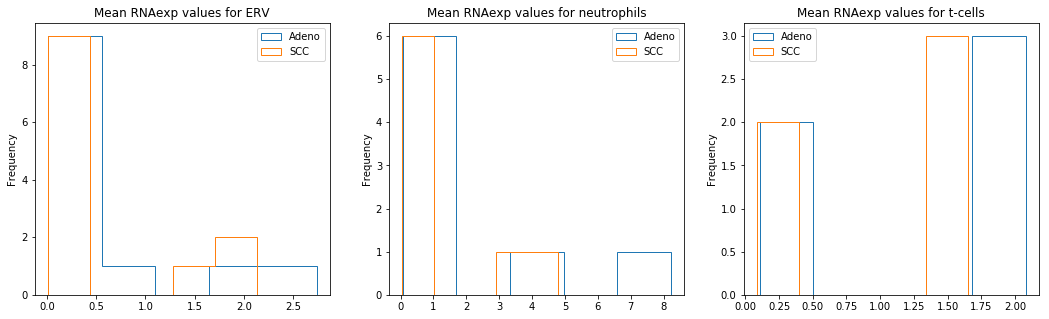

In [212]:
fig, ax = plt.subplots(ncols=3, figsize=(18,5))
df_erv['RNAex'].loc[df_erv['RNAex'].Diagnosis=='Lung Adenocarcinoma', erv_rna]\
                                                    .mean(axis=0).plot.hist(bins=5, histtype='step', ax=ax[0], label='Adeno')
df_erv['RNAex'].loc[df_erv['RNAex'].Diagnosis=='Lung Squamous Cell Carcinoma', erv_rna]\
                                                    .mean(axis=0).plot.hist(bins=5, histtype='step', ax=ax[0], label='SCC')

df_erv['RNAex'].loc[df_erv['RNAex'].Diagnosis=='Lung Adenocarcinoma', neutro_rna]\
                                                    .mean(axis=0).plot.hist(bins=5, histtype='step', ax=ax[1], label='Adeno')
df_erv['RNAex'].loc[df_erv['RNAex'].Diagnosis=='Lung Squamous Cell Carcinoma', neutro_rna]\
                                                    .mean(axis=0).plot.hist(bins=5, histtype='step', ax=ax[1], label='SCC')

df_erv['RNAex'].loc[df_erv['RNAex'].Diagnosis=='Lung Adenocarcinoma', tcell_rna]\
                                                    .mean(axis=0).plot.hist(bins=5, histtype='step', ax=ax[2], label='Adeno')
df_erv['RNAex'].loc[df_erv['RNAex'].Diagnosis=='Lung Squamous Cell Carcinoma', tcell_rna]\
                                                    .mean(axis=0).plot.hist(bins=5, histtype='step', ax=ax[2], label='SCC')

ax[0].set_title('Mean RNAexp values for ERV')
ax[1].set_title('Mean RNAexp values for neutrophils')
ax[2].set_title('Mean RNAexp values for t-cells')
ax[0].legend(loc=1)
ax[1].legend(loc=1)
ax[2].legend(loc=2)

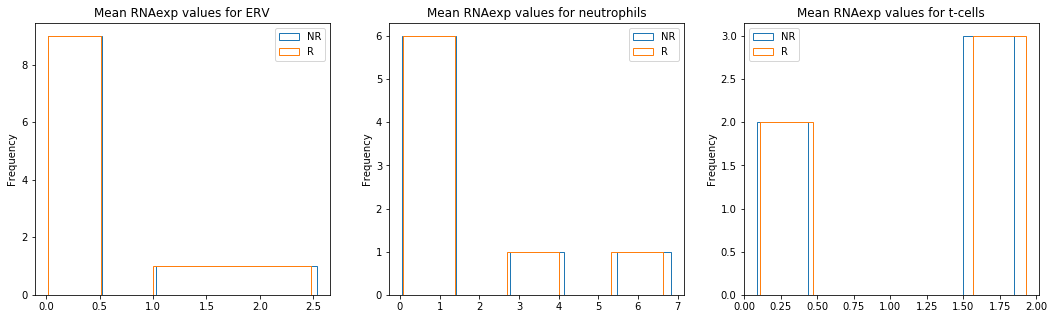

In [183]:
fig, ax = plt.subplots(ncols=3, figsize=(18,5))
df_erv['RNAex'].loc[df_erv['RNAex'].RTT==0, erv_rna]\
                                                    .mean(axis=0).plot.hist(bins=5, histtype='step', ax=ax[0], label='NR')
df_erv['RNAex'].loc[df_erv['RNAex'].RTT==1, erv_rna]\
                                                    .mean(axis=0).plot.hist(bins=5, histtype='step', ax=ax[0], label='R')

df_erv['RNAex'].loc[df_erv['RNAex'].RTT==0, neutro_rna]\
                                                    .mean(axis=0).plot.hist(bins=5, histtype='step', ax=ax[1], label='NR')
df_erv['RNAex'].loc[df_erv['RNAex'].RTT==1, neutro_rna]\
                                                    .mean(axis=0).plot.hist(bins=5, histtype='step', ax=ax[1], label='R')

df_erv['RNAex'].loc[df_erv['RNAex'].RTT==0, tcell_rna]\
                                                    .mean(axis=0).plot.hist(bins=5, histtype='step', ax=ax[2], label='NR')
df_erv['RNAex'].loc[df_erv['RNAex'].RTT==1, tcell_rna]\
                                                    .mean(axis=0).plot.hist(bins=5, histtype='step', ax=ax[2], label='R')

ax[0].set_title('Mean RNAexp values for ERV')
ax[1].set_title('Mean RNAexp values for neutrophils')
ax[2].set_title('Mean RNAexp values for t-cells')
ax[0].legend(loc=1)
ax[1].legend(loc=1)
ax[2].legend(loc=2)

In [1]:
# relationship between ERV/T-cell/Neutrophils

In [ ]:
# Graph embeddings 

# Patient-to-patient clusters
## try MCL with Hadamard product and sum of logs

# ICA/CCA